Initial analysis of results on 40 vs rest for different datasets

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if "notebooks" in os.getcwd():
    home_dir = os.getcwd()

os.chdir(os.path.join("..", "results"))

raw_results = pd.read_csv("40vs_rest_cell_line_results.csv")

os.chdir(home_dir)

In [2]:
raw_results["dataset"] = [do.split("/")[-1].replace("matricies", "matrices").split("matrices_")[-1]
                          for do in raw_results["data_origin"].tolist()]

overview_only = raw_results[raw_results["Cell_line_id"]=="ALL_LINES"].copy()
lines_only = raw_results[raw_results["Cell_line_id"]!="ALL_LINES"].copy()
valid_only = lines_only[lines_only["data_split"]=="valid"].copy()

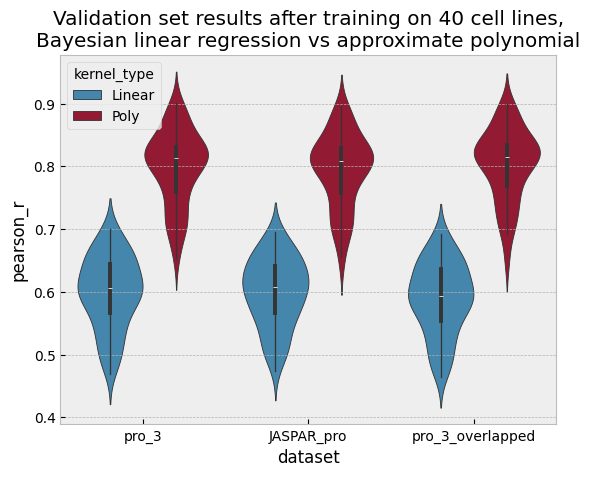

In [3]:
plt.style.use("bmh")
sns.violinplot(x="dataset", y="pearson_r", hue="kernel_type", data=valid_only)
plt.title("Validation set results after training on 40 cell lines,\nBayesian linear regression vs approximate polynomial")
plt.savefig("valid_set_results.png")

In [4]:
unique_lines = valid_only["Cell_line_id"].unique()
datasets = valid_only["dataset"].unique()

In [5]:
xlin, xpoly = [], []
for unique_line in unique_lines:
    xsub_lin, xsub_poly = [], []
    subset = valid_only[valid_only["Cell_line_id"]==unique_line]
    subset_lin = subset[subset["kernel_type"]=="Linear"]
    subset_poly = subset[subset["kernel_type"]=="Poly"]

    for dataset in datasets:
        xsub_lin.append(subset_lin[subset_lin["dataset"]==dataset].iloc[0,2])
        xsub_poly.append(subset_poly[subset_poly["dataset"]==dataset].iloc[0,2])

    xlin.append(np.array(xsub_lin))
    xpoly.append(np.array(xsub_poly))

xlin = np.stack(xlin)
xpoly = np.stack(xpoly)

In [6]:
def plot_colcomp(x, col1, col2, dataset_list, kernel_type, axis, color="blue"):
    minval = np.min([x[:,col1].min(), x[:,col2].min()])
    maxval = np.max([x[:,col1].max(), x[:,col2].max()])
    eq_line = np.linspace(minval, maxval, 50)

    axis.scatter(x[:,col1], x[:,col2], color=color)
    axis.plot(eq_line, eq_line, linestyle="dashed", color="black")
    axis.set_xlabel(f"Pearson r for {dataset_list[col1]}")
    axis.set_ylabel(f"Pearson r for {dataset_list[col2]}")
    axis.set_title(f"{kernel_type} validation results for\n{dataset_list[col1]} vs {dataset_list[col2]}")

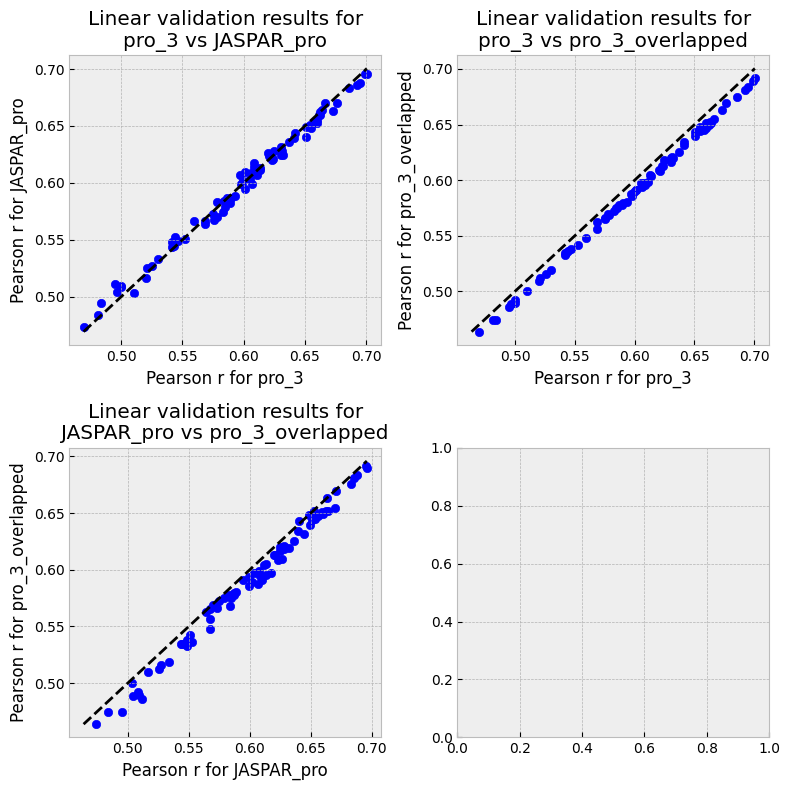

In [7]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))
for (c1, c2, ax) in [(0,1,ax1), (0,2,ax2), (1,2,ax3)]:
    plot_colcomp(xlin, c1, c2, datasets, "Linear", ax)
plt.tight_layout()
plt.savefig("linvalid.png")
plt.show()

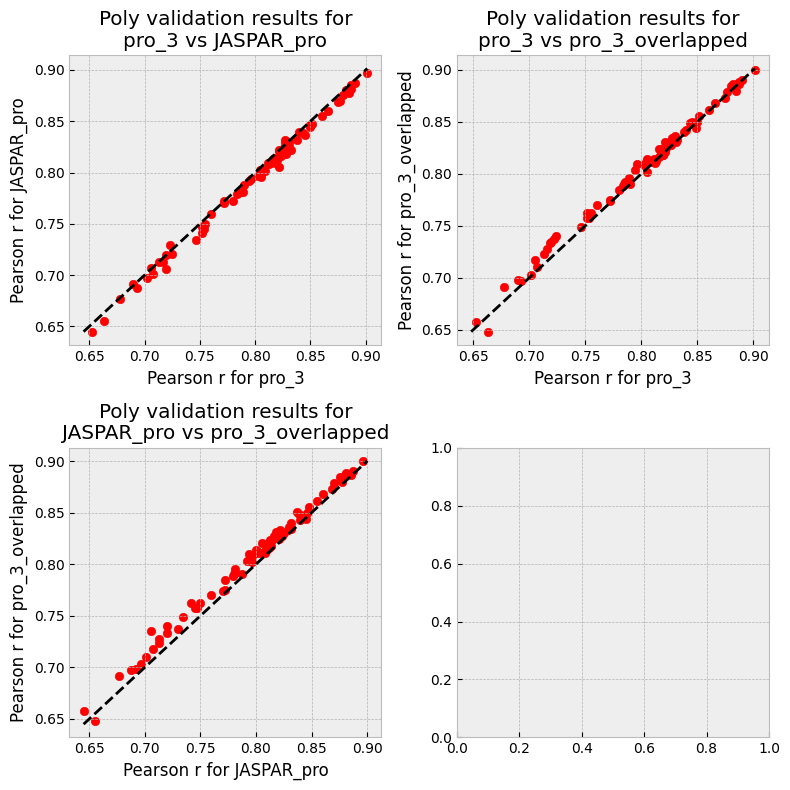

In [8]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))
for (c1, c2, ax) in [(0,1,ax1), (0,2,ax2), (1,2,ax3)]:
    plot_colcomp(xpoly, c1, c2, datasets, "Poly", ax, "red")
plt.tight_layout()
plt.savefig("polyvalid.png")
plt.show()

In [9]:
descriptors, kernels, diffs = [], [], []
for i in range(3):
    for j in range(i+1,3):
        dset1, dset2 = datasets[i], datasets[j]
        kernels += ["Linear" for k in range(xlin.shape[0])]
        diffs += (xlin[:,i] - xlin[:,j]).tolist()
        descriptors += [f"{dset1} minus {dset2}" for k in range(xlin.shape[0])]

        kernels += ["Poly" for k in range(xlin.shape[0])]
        diffs += (xpoly[:,i] - xpoly[:,j]).tolist()
        descriptors += [f"{dset1} minus {dset2}" for k in range(xlin.shape[0])]

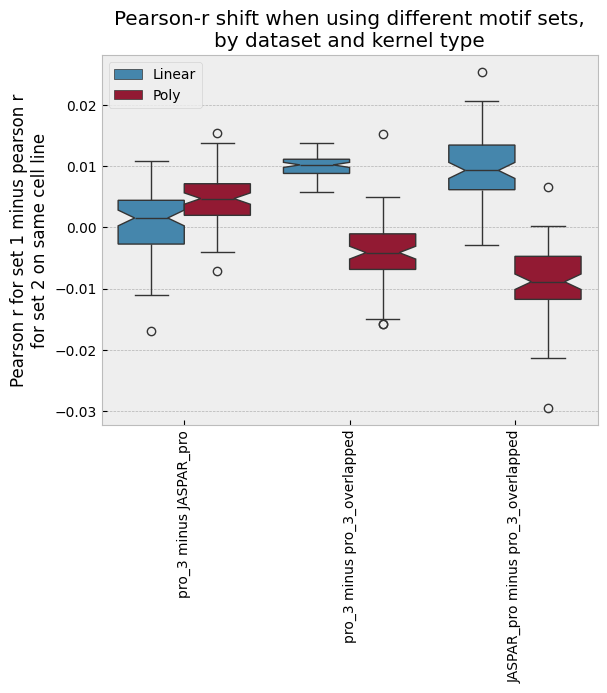

In [14]:
sns.boxplot(x=descriptors, hue=kernels, y=diffs, notch=True)
plt.xticks(rotation=90)
plt.title("Pearson-r shift when using different motif sets,\nby dataset and kernel type")
plt.ylabel("Pearson r for set 1 minus pearson r\nfor set 2 on same cell line")
plt.savefig("comp1.png")